## MNIST CNN (Keras + Tensorflow)


### Get started
Assuming you have Keras > 2.2 and Tensorflow > 1.10, you will need the following libraries for comparison
- Install **DeepExplain**
https://github.com/marcoancona/DeepExplain
- Install **DeepLIFT**
https://github.com/kundajelab/deeplift
- Install **SHAP**
https://github.com/slundberg/shap

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os, pickle
sys.path.insert(0, os.path.abspath('../..'))
#os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

import keras
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Activation, Input, Conv2D, MaxPooling2D
from keras import regularizers
from keras import backend as K
import numpy as np
import tensorflow as tf
import scipy
print ("Using TF:", tf.__version__)
print ("Using Keras:", keras.__version__)

# Import DASP
from dasp import DASP

#Import DeepLift
# Installation instructions: https://github.com/kundajelab/deeplift
import deeplift
from deeplift.layers import NonlinearMxtsMode
from deeplift.conversion import kerasapi_conversion as kc
from deeplift.util import compile_func

# Import Deep Explain (for Grad * Input, Integrated Gradients and Occlusion implementations)
# Installation instructions: https://github.com/marcoancona/DeepExplain
from deepexplain.tensorflow import DeepExplain

Using TensorFlow backend.


Using TF: 1.12.0
Using Keras: 2.2.4


In [4]:
# Build and train a network.

SKIP_TRAIN = True # after first run, this can be set to True
saved_model_file = '.model_cnn.h5'
saved_model_weights_file = '.model_weights.h5'

batch_size = 128
num_classes = 10
epochs = 6

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(-1, img_rows,img_cols,1)
x_test = x_test.reshape(-1, img_rows,img_cols,1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
x_train = (x_train - 0.5) * 2
x_test = (x_test - 0.5) * 2
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# LeNet-5
model = Sequential()
model.add(Conv2D(6, kernel_size=(5, 5),activation='relu',input_shape=x_train.shape[1:], name='conv_1'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (5, 5), activation='relu', name='conv_2'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(120, activation='relu', name='dense_1'))
model.add(Dense(84, activation='relu', name='dense_2'))
model.add(Dense(num_classes, name='dense_3'))
model.add(Activation('softmax'))
# ^ IMPORTANT: notice that the final softmax must be in its own layer 
# if we want to target pre-softmax units

if SKIP_TRAIN is True:
    model = load_model(saved_model_file)
else:  
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
    model.save(saved_model_file)
    model.save_weights(saved_model_weights_file)

model.summary()   
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

60000 train samples
10000 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 6)         0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 8, 8, 16)          2416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               30840     
_________________________________________________________________
dense_2 (Dense)              (None, 8

### Define a subset of the test set to generate explanations for

In [4]:
xs = x_test[0:20]
ys = y_test[0:20]

a_intgrad = np.zeros_like(xs)
a_res = np.zeros_like(xs)
a_rc = np.zeros_like(xs)
a_occlusion = np.zeros_like(xs)
a_dasp = np.zeros_like(xs)
a_sampling = np.zeros_like(xs)

### Use Deep Shapley propagation to compute approximate Shapley Values.
Notice that this requires to convert our original model into a propababilistic one. We provide probabilistic layers for this.
Also, this will require O(c*n) evaluations of the probabilistic network, where n is the number of input features and c is the number of coalition sizes to be tested (ideally c = n)

In [5]:
# Clone the model to remove last softmax activation
reduced_model = Model(model.inputs, model.layers[-2].output)
# Init DASP
dasp = DASP(reduced_model)
# Get model description (optional)
dasp.model_summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
conv_1 (ProbConv2DInput)        (None, 24, 24, 6, 4) 156         input_1[0][0]                    
                                                                 input_2[0][0]                    
          

In [6]:
# Run DASP with 16 coalition sizes (enough for convergence)
dasp_results = dasp.run(xs, 16)
# Select only the explanation for the target unit corresponding to the correct class
a_dasp = np.array([dasp_results[i, c, :] for i, c in enumerate(np.argmax(ys, 1))])

### Use DeepExplain framework to compute attributions using Gradient * Input, Integrated Gradients and Occlusion
Occlusion is performed by replacing one pixel at the time with a zero value and measuring the difference in the target output caused by such occlusion.

In [7]:
%%time
with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = model.layers[-2].output)
    target_tensor = fModel(input_tensor)
    
    a_gradin = de.explain('grad*input', target_tensor * ys, input_tensor, xs)
    a_intgrad = de.explain('intgrad', target_tensor * ys, input_tensor, xs)
    a_occlusion = de.explain('occlusion', target_tensor * ys, input_tensor, xs)
    print ("Done")

DeepExplain: running "grad*input" explanation method (2)
Model with multiple inputs:  False
DeepExplain: running "intgrad" explanation method (3)
Model with multiple inputs:  False
DeepExplain: running "occlusion" explanation method (6)
Model with multiple inputs:  False
Input shape: (28, 28, 1); window_shape (1, 1, 1); step 1
Done
CPU times: user 1.33 s, sys: 40 ms, total: 1.37 s
Wall time: 1.12 s


### Use DeepLIFT framework to compute attributions according to both Rescale and RevealCancel methods

In [8]:
%%time
# Compute DeepLift attributions
revealcancel_model = kc.convert_model_from_saved_files(
                            h5_file=saved_model_file,
                            nonlinear_mxts_mode=NonlinearMxtsMode.RevealCancel)

    
    
rescale_model = kc.convert_model_from_saved_files(
                            h5_file=saved_model_file,
                            nonlinear_mxts_mode=NonlinearMxtsMode.Rescale)

revealcancel_func = revealcancel_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)
rescale_func = rescale_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)

a_rc = np.array([np.array(revealcancel_func(
                task_idx=np.argmax(y),
                input_data_list=[[x]],
                input_references_list=[[np.zeros_like(x)]],
                batch_size=100,
                progress_update=None)) for x, y in zip(xs,ys)])

a_res = np.array([np.array(rescale_func(
                task_idx=np.argmax(y),
                input_data_list=[[x]],
                input_references_list=[[np.zeros_like(x)]],
                batch_size=100,
                progress_update=None)) for x, y in zip(xs,ys)])

nonlinear_mxts_mode is set to: RevealCancel
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will prioritise that use-case
nonlinear_mxts_mode is set to: Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will prioritise that use-case
CPU times: user 32.9 s, sys: 52 ms, total: 32.9 s
Wall time: 33.3 s


### Use Shapley sampling to approximate the Ground Truth
Notice that this might take a while. Sampling method as described in https://www.sciencedirect.com/science/article/pii/S0305054808000804

In [9]:
from utils.shapley_sampling import run_shapley_sampling
a_sampling = run_shapley_sampling(fModel, xs, ys, runs=2**10, feat_dims=[1,2])
print ("Done")

Data shape:  [20, 28, 28, 1]
Runs 1024
Shape to mask features:  [20, -1, 1]
Done


## Plot attribution maps for qualitative comparison

In [10]:
attributions = [
    ('Integrated\nGradients',      a_intgrad.reshape(xs.shape)), 
    ('DeepLIFT\n(Rescale)',        a_res.reshape(xs.shape)), 
    ('DeepLIFT\n(RevCancel)',      a_rc.reshape(xs.shape)), 
    ('Occlusion',                  a_occlusion.reshape(xs.shape)), 
    ('DASP (ours)',                a_dasp.reshape(xs.shape)), 
    ('Sampling\n(Ground Truth)',   a_sampling.reshape(xs.shape))
]

Save
(20, 28, 28, 1)


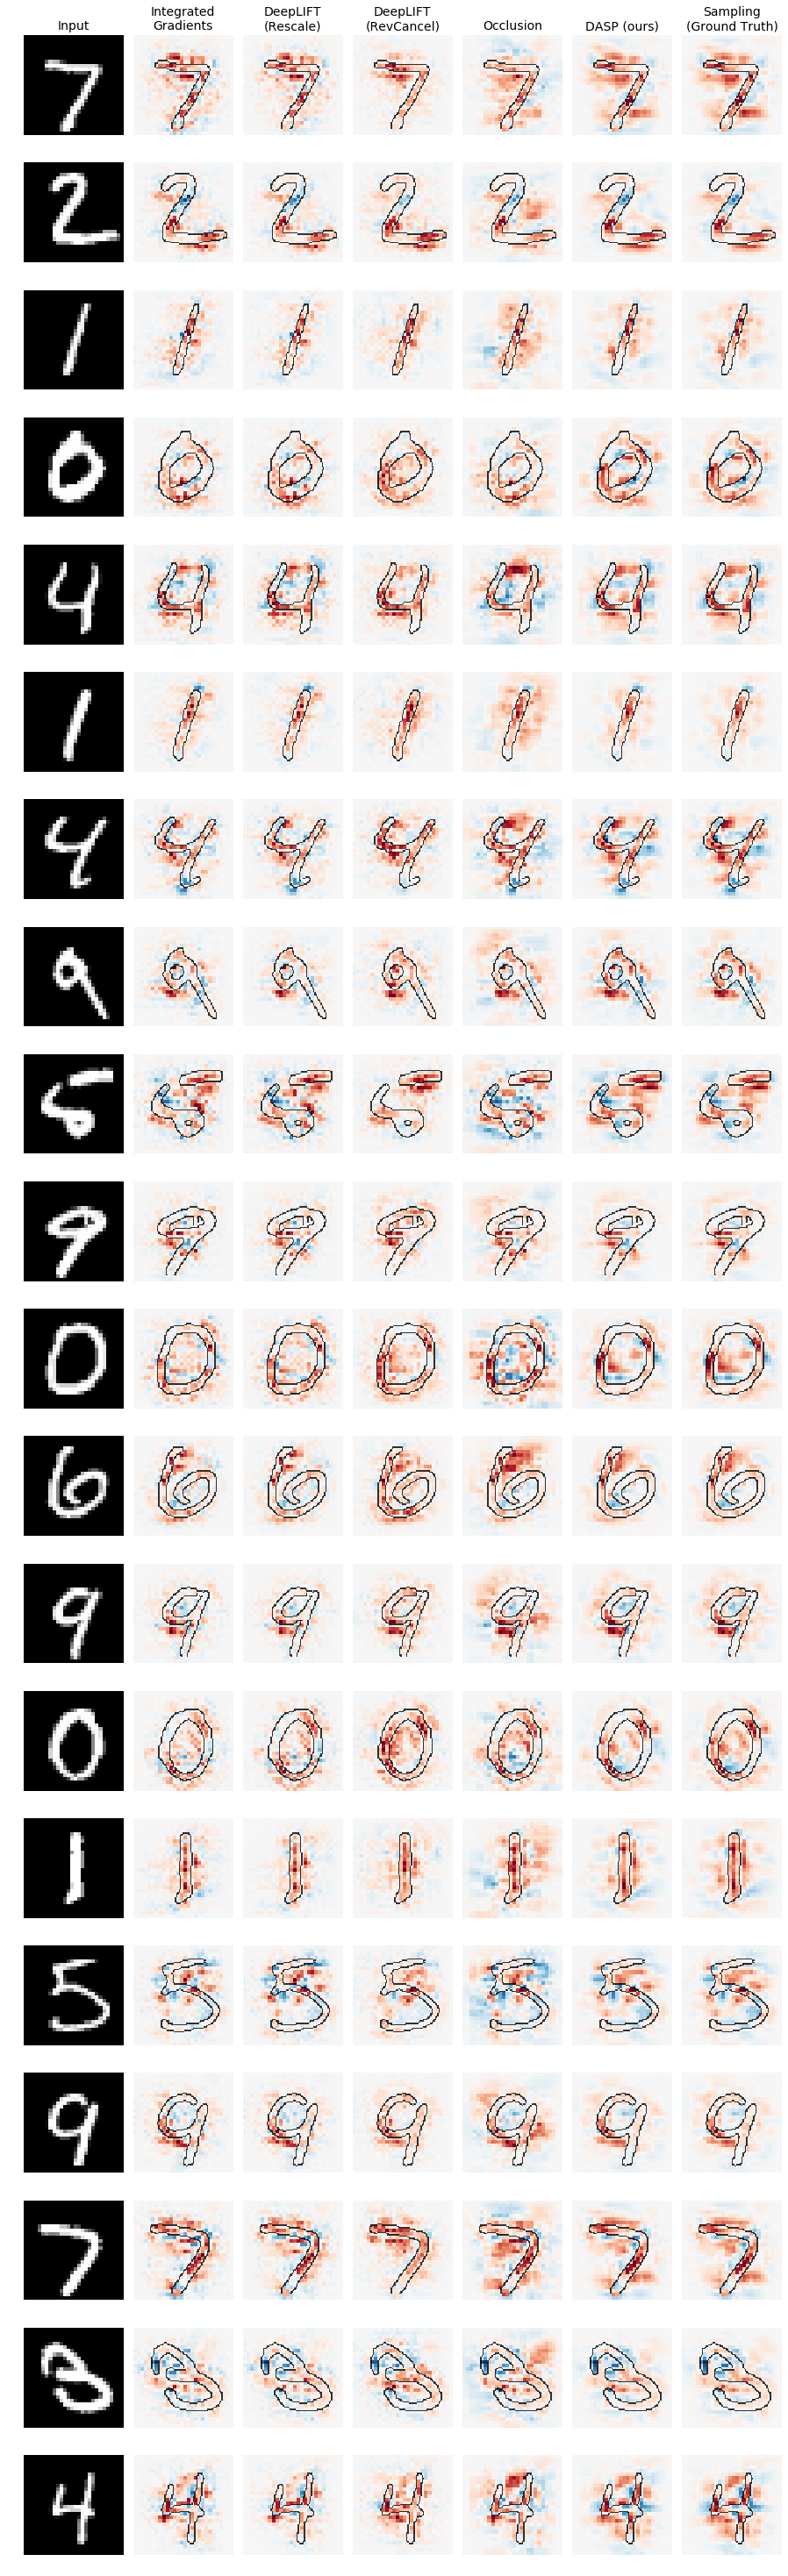

In [23]:
# Plot attributions
%matplotlib inline
from utils.utils import plot_attribution_maps

# Plot all
plot_attribution_maps("mnist_cnn", xs, [x[1] for x in attributions], [x[0] for x in attributions], idxs=range(20), show_original=True, save_separate=True)

## Quantitative comparison (MSE and Spearman rank correlation)

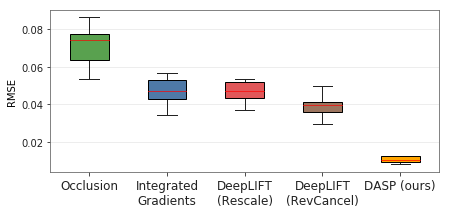

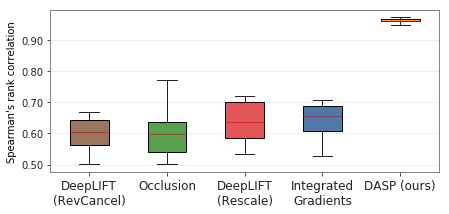

In [13]:
from utils.utils import plot_mse_comparison, plot_correlation_comparison

plot_mse_comparison("mnist_cnn", [x[1] for x in attributions], [x[0] for x in attributions], gt_idx=-1)
plot_correlation_comparison("mnist_cnn", [x[1] for x in attributions], [x[0] for x in attributions], gt_idx=-1)

## Quantitative comparison (pixel perturbation)
Pixels in the original images are ranked by their attribution value and sequentially "removed" by setting their value to zero. We expect good explanations to highlight pixels that are important for the classification. Assuming that the importance of a pixels is positively correlated with its marginal contribution to the output, we expect the target output to drop faster when the most important pixels are removed first. These curve showa the output variations while pixels are removed according to the ranking given by the different methods. Better methods produce the largest variations. See "Evaluating the visualization of what a Deep Neural Network has learned", Samek et al., 2015 for details.

Running robustness test...


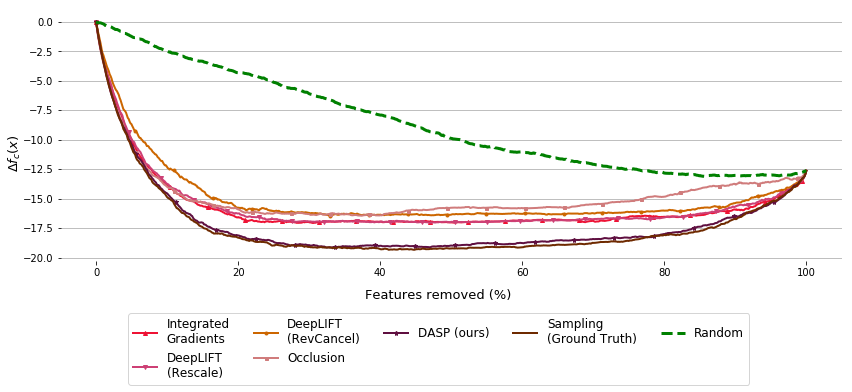

In [14]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from utils.accuracy_robustness import run_robustness_test
init_notebook_mode(connected=True)

run_robustness_test(fModel, xs, ys,  [x[1] for x in attributions], [x[0] for x in attributions], 'mnist_cnn', 1,
                        result_path='.', mode='prediction', reduce_dim=None)